In [32]:
import env
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utilities as utils

In [11]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [12]:
# begin cleaning up the timestamp by removing the brackets and extraneous tail

df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

# replace the first colon in the timestamp before year 
# to accomodate for pandas datetime
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

# reset index to time
df = utils.set_index_to_datetime(df, 'timestamp')

# clean up strings in columns with extra quotes
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

# simplify and clean up request method by removing page data
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df['size_mb'] = [n/1024/1024 for n in df['size']]

In [13]:
ip_df = utils.generate_counts_and_probability_df(df, 'ip')

In [14]:
ip_df.head()

,ip,ip_count,ip_proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


In [15]:
ip_df.shape

(22, 3)

In [16]:
# alter the ip df to only see those where rate < 1% 
ip_df[ip_df.ip_proba < 0.01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,70.121.214.34,2,0.000143
7,52.87.230.102,2,0.000143
8,35.175.171.137,2,0.000143
9,3.92.201.136,1,0.000072
10,34.207.64.242,1,0.000072
11,52.90.165.200,1,0.000072
12,3.88.129.158,1,0.000072
13,97.105.15.120,1,0.000072


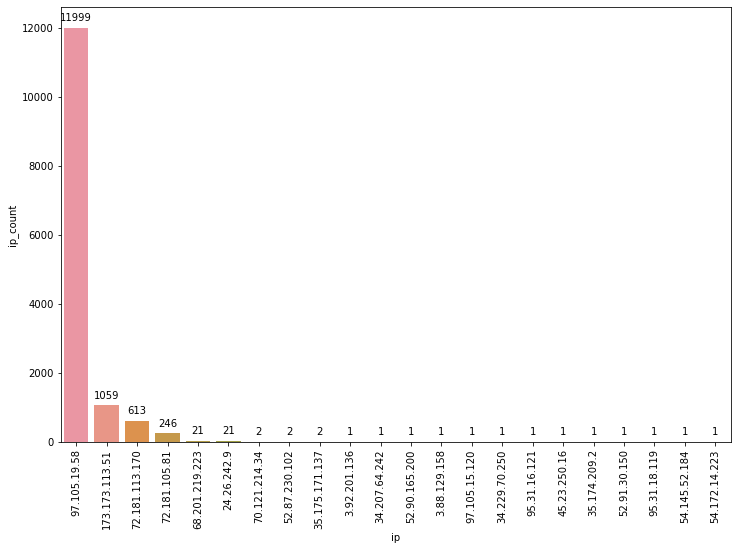

In [18]:
utils.visualize_target_counts(ip_df, 'ip', 'ip_count')

In [19]:
# create a training set
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [20]:
train.size / df.size

0.9997138360280441

In [21]:
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

In [22]:
ip_df = utils.generate_column_probability_df(train, 'ip')

In [23]:
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')

In [24]:
# value counts?
df[df['ip_proba'] == 0]

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba
timestamp,,,,,,,,
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,0,python-requests/2.21.0,0.000958,0.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,2560,0,python-requests/2.21.0,0.002441,0.0
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,0,python-requests/2.21.0,1.099591,0.0


In [26]:
status_given_ip = utils.generate_conditional_probability_df(train, 'status', 'ip')

In [27]:
status_given_ip

,ip,status,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [28]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                              count().reset_index().\
                              rename(columns={'request_method': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)

In [29]:
ip_status

,ip,status,proba_status_given_ip,ip_status_count
0,173.173.113.51,200,1.000000,1059
1,24.26.242.9,200,1.000000,21
2,3.88.129.158,200,1.000000,1
3,3.92.201.136,200,1.000000,1
4,34.207.64.242,200,1.000000,1
5,34.229.70.250,200,1.000000,1
6,35.174.209.2,200,1.000000,1
7,35.175.171.137,200,1.000000,2
8,45.23.250.16,200,1.000000,1
9,52.87.230.102,200,1.000000,2


In [30]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')

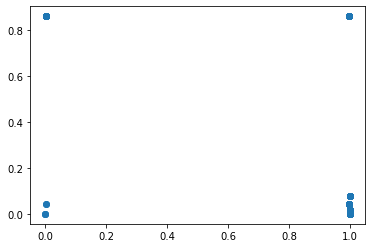

In [33]:
# scatter plot
plt.scatter(df.proba_status_given_ip, df.ip_proba)
plt.show()

In [34]:
df[(df['proba_status_given_ip'] > 0.9) & (df['ip_proba'] < 0.2)]

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:39:14,3.92.201.136,GET / HTTP/1.1,200,42,0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040,0.000072,1.0,1.0
2019-04-16 19:39:15,52.90.165.200,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,0.000072,1.0,1.0
2019-04-16 19:40:32,3.88.129.158,GET /api/v1/items HTTP/1.1,200,3561,0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.003396,0.000072,1.0,1.0
2019-04-16 19:40:33,34.207.64.242,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,0.000072,1.0,1.0
2019-04-16 19:40:36,54.172.14.223,GET /api/v1/ HTTP/1.1,200,162,0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000154,0.000072,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2019-04-17 06:15:07,24.26.242.9,GET /api/v1/sales HTTP/1.1,200,493905,0,python-requests/2.21.0,0.471025,0.001503,1.0,21.0
2019-04-17 06:16:10,24.26.242.9,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.001503,1.0,21.0
2019-04-17 06:16:10,24.26.242.9,GET /api/v1/stores HTTP/1.1,200,1328,0,python-requests/2.21.0,0.001266,0.001503,1.0,21.0
